# Analyze runtimes

Analyze the runtimes of the injections we did

## Preamble

In [24]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import json
import h5py

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import Latex

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)
import copy

# from utils_compare_runs import paths_dict

In [25]:
outdirs_injections = {"TF2": "../injections/outdir_TF2/",
                      "NRTv2": "../injections/outdir_NRTv2/"}

jim_root_path = "/home/thibeau.wouters/TurboPE-BNS/real_events/"
bilby_root_path = "/home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/"
paths_dict = {"GW170817_TaylorF2": {"jim": jim_root_path + "GW170817_TaylorF2/outdir_snellius/",
                    "bilby": bilby_root_path + "GW170817_TF2_with_tukey_fix_result.json"},
              
              "GW170817_NRTidalv2": {"jim": jim_root_path + "GW170817_NRTidalv2/outdir_snellius/",
                                     "bilby": bilby_root_path + "GW170817_IMRPhenomD_NRTidalv2_result.json",
                    },
              
              "GW190425_TaylorF2": {"jim": jim_root_path + "GW190425_TaylorF2/outdir_snellius/",
                                    "bilby": bilby_root_path + "GW190425_TF2_with_tukey_fix_result.json",
                    },
              
              "GW190425_NRTidalv2": {"jim": jim_root_path + "GW190425_NRTidalv2/outdir_snellius/",
                                     "bilby": bilby_root_path + "GW190425_IMRPhenomD_NRTidalv2_result.json",
                    },
}

### Old version
# jim_paths = {"GW170817_TaylorF2": "../real_events/GW170817_TaylorF2/outdir/",
#              "GW170817_NRTidalv2": "../real_events/GW170817_NRTidalv2/outdir/",
#              "GW190425_TaylorF2": "../real_events/GW190425_TaylorF2/outdir/",
#              "GW190425_NRTidalv2": "../real_events/GW190425_NRTidalv2/outdir/"}

# bilby_paths = {"GW170817_TaylorF2": "/home/thibeau.wouters/jim_pbilby_samples/GW170817/GW170817-TF2_rejection_sampling_result.json",
#                "GW170817_NRTidalv2": "/home/thibeau.wouters/jim_pbilby_samples/GW170817/GW170817_IMRDNRTv2_older_bilby_result.json",
#                "GW190425_TaylorF2": "/home/thibeau.wouters/jim_pbilby_samples/GW190425/GW190425-TF2_result.json",
#                "GW190425_NRTidalv2": "/home/thibeau.wouters/jim_pbilby_samples/GW190425/GW190425_IMRDNRTv2_older_bilby_result.json"}

# run_names = list(jim_paths.keys())

In [26]:
def format_runtime(runtime_minutes: float, 
                   nb_round: int = 2) -> str:
    """
    Simple function to format the runtime in minutes appropriately.

    Args:
        runtime_minutes (float): Runtime in minutes
        nb_round (int, optional): Number of digits for rounding. Defaults to 2.

    Returns:
        str: Nicely formatted runtime
    """
    runtime_string = str(np.round(runtime_minutes, nb_round))
    before, after = runtime_string.split(".")
    if len(after) == 1:
        runtime_string = before + "." + after + "0" 
        
    if len(runtime_string) == 4:
        runtime_string = "\\phantom{0}" + runtime_string
        
    return runtime_string

In [27]:
def fetch_runtime_injection(run_dir: str,
                      nb_round: int = 2) -> float:
    """
    Fetch the runtime of a given run directory of a jim run.

    Args:
        run_dir (str): Directory of the run, i.e. the outdir

    Returns:
        float: Runtime.
    """
    
    # Fetch runtimes of the individual parts:
    with open(run_dir + "/runtime.txt", "r") as f:
        runtime_seconds = float(f.read())
        
    runtime_minutes = runtime_seconds / 60
    runtime_string = format_runtime(runtime_minutes, nb_round)
            
    return runtime_seconds, runtime_string

In [28]:
def fetch_runtime_event(run_dir: str,
                      nb_round: int = 2) -> float:
    """
    Fetch the runtime of a given run directory of a jim run.

    Args:
        run_dir (str): Directory of the run, i.e. the outdir

    Returns:
        float: Runtime.
    """
    
    # Fetch runtimes of the individual parts:
    with open(run_dir + "/runtime.txt", "r") as f:
        runtime_seconds = float(f.read())
        
    # Note: the reruns were done with 1000 loops for evosax, but the fixed ref params used 2000 loops, so adding that once more
    with open(run_dir + "/runtime_evosax.txt", "r") as f:
        runtime_seconds += float(f.read())
        
    runtime_minutes = runtime_seconds / 60
    runtime_string = format_runtime(runtime_minutes, nb_round)
            
    return runtime_seconds, runtime_string

In [29]:
def fetch_runtime_evosax_event(run_dir: str,
                               nb_round: int = 2) -> float:
    """
    Fetch the runtime of a given real event run spent only on the evosax (computing reference parameters).

    Args:
        run_dir (str): Directory of the run, i.e. the outdir

    Returns:
        float: Runtime.
    """
    
    # Note: the reruns were done with 1000 loops for evosax, but the fixed ref params used 2000 loops, so adding that once more
    with open(run_dir + "/runtime_evosax.txt", "r") as f:
        runtime_seconds = 2 * float(f.read())
        
    runtime_minutes = runtime_seconds / 60
    runtime_string = format_runtime(runtime_minutes, nb_round)
            
    return runtime_seconds, runtime_string

In [30]:
def fetch_runtime_bilby(event_name: str, 
                        nb_round: int = 2,
                        convert_to_hours: bool = True) -> tuple[float, str]:
    """
    Fetch and format the runtime of analyzing one of the real events for bilby. 

    Args:
        event_name (str): Identifier of the event, format GW_WF, e.g. GW170817_TaylorF2
        outdir_name (str): Name of the outdir, e.g. `outdir`
        runtime_filename (str, optional): _description_. Defaults to "runtime.txt".
        nb_round (int, optional): _description_. Defaults to 2.

    Returns:
        tuple: Tuple of float value, being the runtime in seconds, and a string with the runtime in minutes
    """
    
    path = paths_dict[event_name]["bilby"]
    print(f"Bilby path: {path}")
    with open(path, "r") as f:
        bilby_data = json.load(f)
        runtime_seconds = float(bilby_data["sampling_time"])
        
    runtime_minutes = runtime_seconds / 60
    if convert_to_hours:
        runtime_minutes /= 60 # TODO fix the naming, or not, if I am too lazy in the end
    runtime_string = format_runtime(runtime_minutes, nb_round)
    
    return runtime_seconds, runtime_string

## Injections runtimes

In [31]:
runtimes_dict = {} 

for name in outdirs_injections.keys():
    outdir = outdirs_injections[name]
    runtimes = []
    for subdir in os.listdir(outdir):
        rundir = outdir + subdir
        runtime_path = rundir + "/runtime.txt"
        
        try:
            runtime, _ = fetch_runtime_injection(rundir)
            runtimes.append(runtime)
        except Exception as e:
            print(f"Skipping {rundir}, error: {e}")
            
    runtimes_dict[name] = np.array(runtimes)

Skipping ../injections/outdir_TF2/injection_54, error: [Errno 2] No such file or directory: '../injections/outdir_TF2/injection_54/runtime.txt'


Make a histogram of the runtimes, more as a sanity check for myself.

In [32]:
minutes = True # whether to convert runtimes to minutes rather than seconds

if minutes:
    denominator = 60
else:
    denominator = 1

hist_TF2, edges = np.histogram(runtimes_dict["TF2"] / denominator, bins = 20, density = True)
hist_NRTv2, _ = np.histogram(runtimes_dict["NRTv2"] / denominator, bins = edges, density = True)

if minutes:
    xlabel = "Runtime (min)"
else:
    xlabel = "Runtime (s)"

stairs_kwargs = {"linewidth": 2}

# Create the figure
plt.figure(figsize=(10, 6))
plt.stairs(hist_TF2, edges, label = "TF2", **stairs_kwargs)
plt.stairs(hist_NRTv2, edges, label = "NRTv2", **stairs_kwargs)

plt.legend()
plt.xlabel(xlabel)
plt.ylabel("Density")
# plt.show()
plt.close()

## Runtimes for compilation and initializing the likelihood

In [33]:
runtimes_compilation_filename = "../data/runtimes_compilation.txt"
runtimes_compilation = np.loadtxt(runtimes_compilation_filename, delimiter=",")

compilation_mean, compilation_std = np.mean(runtimes_compilation), np.std(runtimes_compilation)
print(f"Compilation: mean +/- std: {compilation_mean / 60:.2f} +/- {compilation_std / 60:.2f} minutes")

compilation_mean_minutes = compilation_mean / 60

Compilation: mean +/- std: 2.59 +/- 0.33 minutes


## Final numbers

Can subtract the time for compiling etc, if wanted:

In [34]:
jim_runtimes_injections_float = {} # in seconds
jim_runtimes_injections = {}
jim_runtimes_injections_median = {}
jim_runtimes_injections_median_str = {}
subtract_number = compilation_mean_minutes # in case we want to extract the compilation time for reporting in the paper
subtract_number = 0 # in case we DO NOT want to extract the compilation time for reporting in the paper

jim_total_runtime_injections = 0

for name, runtimes in runtimes_dict.items():
    
    # subtract compilation time in seconds
    jim_total_runtime_injections += np.sum(runtimes - subtract_number * 60)
    
    ### Mean +/- std:
    mean_str = format_runtime(np.mean(runtimes / denominator) - subtract_number)
    std_str = format_runtime(np.std(runtimes / denominator))
    median_value = np.median(runtimes / denominator) - subtract_number
    median_str = format_runtime(median_value)
    
    jim_runtimes_injections_float[name] = np.mean(runtimes) # in seconds
    jim_runtime_str = r"$({} \pm {})$ min".format(mean_str, std_str)
    print(f"Mean and std for {name}")
    print(jim_runtime_str)
    jim_runtimes_injections[name] = jim_runtime_str
    
    ### Median:
    median_str = r"${}$ min".format(median_str)
    
    jim_runtimes_injections_median[name] = median_value
    jim_runtimes_injections_median_str[name] = median_str
    
    # Print
    print(f"Median for {name}")
    print(median_value)
    print(median_str)

Mean and std for TF2
$(27.09 \pm 12.18)$ min
Median for TF2
24.758970030148824
$24.76$ min
Mean and std for NRTv2
$(21.10 \pm \phantom{0}9.16)$ min
Median for NRTv2
18.02008366982142
$18.02$ min


## Fetch jim runtimes

In [35]:
run_names = list(paths_dict.keys())
print(run_names)

jim_runtimes_float = {}
jim_runtimes_str = {}

jim_runtimes_float_evosax = {}
jim_runtimes_str_evosax = {}

jim_runtimes_float_sampling = {} # total runtime - evosax time
jim_runtimes_str_sampling = {}


for run in run_names:
    print(run)
    path = paths_dict[run]["jim"]
    path = path.replace("/outdir/", "/outdir_snellius/")
    print(f"Fetching runtimes from run: {path}")
    runtime_float, runtime_str = fetch_runtime_event(path)
    runtime_float_evosax, runtime_str_evosax = fetch_runtime_evosax_event(path)
    print(runtime_float)
    print(runtime_float_evosax)
    
    runtime_float_sampling = runtime_float - runtime_float_evosax
    runtime_str_sampling = format_runtime(runtime_float_sampling / 60)
    
    # Overall runtime
    jim_runtimes_float[run] = runtime_float
    jim_runtimes_str[run] = runtime_str
    
    # Runtime for evosax
    jim_runtimes_float_evosax[run] = runtime_float_evosax
    jim_runtimes_str_evosax[run] = runtime_str_evosax
    
    # Runtime for total - evosax
    jim_runtimes_float_sampling[run] = runtime_float_sampling
    jim_runtimes_str_sampling[run] = runtime_str_sampling

['GW170817_TaylorF2', 'GW170817_NRTidalv2', 'GW190425_TaylorF2', 'GW190425_NRTidalv2']
GW170817_TaylorF2
Fetching runtimes from run: /home/thibeau.wouters/TurboPE-BNS/real_events/GW170817_TaylorF2/outdir_snellius/
1602.3845567703247
582.1537246704102
GW170817_NRTidalv2
Fetching runtimes from run: /home/thibeau.wouters/TurboPE-BNS/real_events/GW170817_NRTidalv2/outdir_snellius/
2022.7856409549713
341.49449348449707
GW190425_TaylorF2
Fetching runtimes from run: /home/thibeau.wouters/TurboPE-BNS/real_events/GW190425_TaylorF2/outdir_snellius/
1296.861796617508
307.6143078804016
GW190425_NRTidalv2
Fetching runtimes from run: /home/thibeau.wouters/TurboPE-BNS/real_events/GW190425_NRTidalv2/outdir_snellius/
1291.1365008354187
368.90935134887695


## Fetch pbilby runtimes

These are the numbers that Peter gave me:

In [36]:
# # Override with the numbers obtained from the log file of the runs instead:
# bilby_runtimes_total = {}
# bilby_runtimes_total["GW170817_TaylorF2"]  = 0.0
# bilby_runtimes_total["GW170817_NRTidalv2"] = 12 * (60) ** 2 + 34 * 60 + 15
# bilby_runtimes_total["GW190425_TaylorF2"]  = 0.0
# bilby_runtimes_total["GW190425_NRTidalv2"] =  5 * (60) ** 2 + 39 * 60 + 38

In [37]:
bilby_runtimes_float = {}
bilby_runtimes_str = {}
for run in run_names:
    path = paths_dict[run]["bilby"]
    print(path)
    runtime_float, runtime_string = fetch_runtime_bilby(run, convert_to_hours=True)
        
    bilby_runtimes_float[run] = runtime_float
    bilby_runtimes_str[run] = runtime_string
    
bilby_runtimes_total = bilby_runtimes_float

/home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW170817_TF2_with_tukey_fix_result.json
Bilby path: /home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW170817_TF2_with_tukey_fix_result.json


/home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW170817_IMRPhenomD_NRTidalv2_result.json
Bilby path: /home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW170817_IMRPhenomD_NRTidalv2_result.json
/home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW190425_TF2_with_tukey_fix_result.json
Bilby path: /home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW190425_TF2_with_tukey_fix_result.json
/home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW190425_IMRPhenomD_NRTidalv2_result.json
Bilby path: /home/thibeau.wouters/jim_pbilby_samples/older_bilby_version/GW190425_IMRPhenomD_NRTidalv2_result.json


In [38]:
# Add dollar signs and minute string
for key, value in jim_runtimes_str.items():
    jim_runtimes_str[key] = f"${value}$ min"

In [39]:
assert list(jim_runtimes_float.keys()) == list(bilby_runtimes_float.keys())
assert list(jim_runtimes_str.keys()) == list(bilby_runtimes_str.keys())

Put hours in the formatting for pbilby

In [40]:
for key, value in bilby_runtimes_str.items():
    bilby_runtimes_str[key] = f"${value}$ h"

## ROQ sampling times

In [41]:
def read_bilby_runtime(path: str) -> float:
    with h5py.File(path, "r") as f:
        runtime = f["sampling_time"][()]
    return runtime

In [42]:
roq_sampling_time_GW170817 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/ROQ/gw170817_ROQ_result.hdf5")
roq_sampling_time_GW190425 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/ROQ/gw190425_ROQ_result.hdf5")

print(f"Sampling time for ROQ GW170817: {roq_sampling_time_GW170817 / 3600} hours")
print(f"Sampling time for ROQ GW190425: {roq_sampling_time_GW190425 / 3600} hours")

avg_runtime_roq = (roq_sampling_time_GW170817 + roq_sampling_time_GW190425) / 2
print(f"Average sampling time for ROQ GW190425: {avg_runtime_roq / 3600} hours")

Sampling time for ROQ GW170817: 1.647744848611111 hours
Sampling time for ROQ GW190425: 0.9662301444444444 hours
Average sampling time for ROQ GW190425: 1.306987496527778 hours


## Relative binning with bilby runtimes

In [43]:
relbin_sampling_time_GW170817_TaylorF2 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/RB/gw170817_relbin_TaylorF2_result.hdf5")
relbin_sampling_time_GW170817_NRTidalv2 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/RB/gw170817_relbin_result.hdf5")
relbin_sampling_time_GW190425_TaylorF2 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/RB/gw190425_relbin_TaylorF2_result.hdf5")
relbin_sampling_time_GW190425_NRTidalv2 = read_bilby_runtime("/home/thibeau.wouters/TurboPE-BNS/RB/gw190425_relbin_result.hdf5")

print(f"Sampling time for RB GW170817 TaylorF2: {relbin_sampling_time_GW170817_TaylorF2 / 3600} hours")
print(f"Sampling time for RB GW170817 NRTidalv2: {relbin_sampling_time_GW170817_NRTidalv2 / 3600} hours")
print(f"Sampling time for RB GW190425 TaylorF2: {relbin_sampling_time_GW190425_TaylorF2 / 3600} hours")
print(f"Sampling time for RB GW190425 NRTidalv2: {relbin_sampling_time_GW190425_NRTidalv2 / 3600} hours")

avg_runtime_relbin = (relbin_sampling_time_GW170817_TaylorF2 + relbin_sampling_time_GW190425_TaylorF2 + relbin_sampling_time_GW170817_NRTidalv2 + relbin_sampling_time_GW190425_NRTidalv2) / 4
print(f"Average sampling time for RB: {avg_runtime_relbin / 3600} hours")

Sampling time for RB GW170817 TaylorF2: 3.176471048333613 hours
Sampling time for RB GW170817 NRTidalv2: 4.680341001666572 hours
Sampling time for RB GW190425 TaylorF2: 2.2960750963888605 hours
Sampling time for RB GW190425 NRTidalv2: 4.680341001666572 hours
Average sampling time for RB: 3.7083070370139044 hours


## Get the ratio of runtimes

In [44]:
runtimes_ratio_float = {}
runtimes_ratio_str = {}

for key in jim_runtimes_float.keys():
    ratio = bilby_runtimes_float[key] / jim_runtimes_float[key]
    runtimes_ratio_float[key] = ratio
    print(ratio)
    runtimes_ratio_str[key] = f"${int(ratio)} \\times $"

21.655774466487056
19.551606753214244
11.334590495563338
13.081609338030004


## Combine into table

This is an older version, remove if not used anymore

In [45]:
# latex_code = '\\begin{{tabular}}{{l l c c c}}\n Event & Waveform & \\texttt{{jim}} & \\texttt{{pbilby}} & Speed-up \\\\\n \hline\\hline\n\\multirow{{2}}{{*}}{{GW170817}} & TF2 & {} & {} & {} \\\\\n & NRTv2 & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{GW190425}}  & TF2 & {} & {} & {} \\\\ \n & NRTv2 & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{Injection}} & TF2 & {} & -- & -- \\\\\n& NRTv2 & {} & -- & -- \\\\\n\\hline\\hline\n\\end{{tabular}}'\
# .format(  jim_runtimes_str["GW170817_TaylorF2"],
#         bilby_runtimes_str["GW170817_TaylorF2"],
#         runtimes_ratio_str["GW170817_TaylorF2"],
#           jim_runtimes_str["GW170817_NRTidalv2"],
#         bilby_runtimes_str["GW170817_NRTidalv2"], 
#         runtimes_ratio_str["GW170817_NRTidalv2"],
#           jim_runtimes_str["GW190425_TaylorF2"], 
#         bilby_runtimes_str["GW190425_TaylorF2"], 
#         runtimes_ratio_str["GW190425_TaylorF2"],
#           jim_runtimes_str["GW190425_NRTidalv2"], 
#         bilby_runtimes_str["GW190425_NRTidalv2"],
#         runtimes_ratio_str["GW190425_NRTidalv2"], 
#         jim_runtimes_injections_median_str["TF2"], 
#         jim_runtimes_injections_median_str["NRTv2"]
#        )

# print(latex_code)

## Comparison with other pipelines than pBilby:

### ROQ methods

"The wall time of construction for Bases 4s-P by PyROQ was 70 hours for the linear basis and 57 hours for the quadratic basis, with 40 CPUs and 102 GB RAM on a LIGO Data Grid cluster. For Bases 8s-P, these numbers are 37 hours and 45 hours, with 40 CPUs and 110 GB RAM." (from the PyROQ paper). 

We will compare against [this paper](https://arxiv.org/abs/2307.13380), which can perform BNS PE in around 5 minutes using an advanced set up of ROQ bases. From browsing the LIGO Gitlab, we find that information regarding the building of the ROQ bases can be found at `/home/soichiro.morisaki/working/online_phenomd_basis`. Note that we compare against IMRPhenomD, as that is used for the low-latency runs, even though we use TaylorF2 and IMRPhenomD_NRTidalv2, which are faster and slower, respectively, compared to IMRPhenomD.

There are several sub directories, probably for various setups of building the bases. Not all of them have log files with respect to the building of the bases, but `d_fhigh1024` does. We will therefore use this specific subdirectory to estimate the wall time needed to compute the ROQ bases. 

In [46]:
roq_log_dir = "/home/soichiro.morisaki/working/online_phenomd_basis/d_fhigh1024/log/"
log_files = [f for f in os.listdir(roq_log_dir) if ".log" in f]

print(f"Number of log files: {len(log_files)}")

Number of log files: 288


In [47]:
from datetime import datetime

def fetch_roq_buildtime(filename, verbose: bool = True):
    start_time = None
    end_time = None
    with open(filename, 'r') as file:
        for line in file:
            if "Job executing on host" in line:
                start_time_str = line.split()[3]  # Extract the time part of the log entry
                if verbose:
                    print("line")
                    print(line)
                
                    print("start_time_str")
                    print(start_time_str)
                start_time = datetime.strptime(start_time_str, "%H:%M:%S").time()

            elif "Job terminated." in line:
                end_time_str = line.split()[3]  # Extract the time part of the log entry
                if verbose:
                    print("line")
                    print(line)
                    
                    print("end_time_str")
                    print(end_time_str)
                
                end_time = datetime.strptime(end_time_str, "%H:%M:%S").time()

    if start_time is None or end_time is None:
        return None  # Couldn't find both start and end times, return None

    # Calculate walltime
    start_datetime = datetime.combine(datetime.now().date(), start_time)
    end_datetime = datetime.combine(datetime.now().date(), end_time)
    walltime = end_datetime - start_datetime
    walltime_seconds = walltime.total_seconds()
    walltime_float = float(walltime_seconds)

    return walltime_float

In [48]:
verbose = False
roq_buildtimes = []
for f in log_files:
    if verbose:
        print("================================================================================================================================================================")
    buildtime = fetch_roq_buildtime(roq_log_dir + f, verbose = verbose)
    if verbose:
        print("================================================================================================================================================================")
    roq_buildtimes.append(buildtime)
    
roq_buildtimes = np.array(roq_buildtimes)
roq_buildtimes_mins = np.array(roq_buildtimes) / 60
total_roq_buildtime = np.sum(roq_buildtimes)

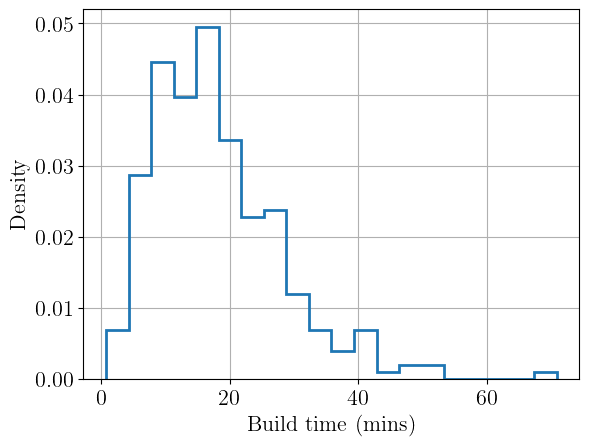

In [49]:
plt.hist(roq_buildtimes_mins, bins=20, density = True, linewidth = 2, histtype = "step")
plt.xlabel("Build time (mins)")
plt.ylabel("Density")
plt.show()

In [50]:
print(f"Total ROQ build time: {total_roq_buildtime / (60 * 60)} hours")

Total ROQ build time: 86.8386111111111 hours


ROQ runtime for GW170817 with IMRPhenomPv2_NRTidalv2, aligned spins

# Environmental impact

- For the GPU consumption, see [1] or [2]: we have 400W for a A100 GPU installed in SXM, which is the case for Snellius [3]. 

- For the CPUs used, look at Ref. [4].

- Conversions to CO2 and trees: these are taken from Ref. [5]

-  In short: "For the capture of 1 tonne of CO2 emissions ~50 trees must grow for one year [6]
^using 0.905 kg of CO2 per kilowatt hour [7]."

- For NL, the most recent value is 0.328 kg CO2 per kWh [8].

[1] https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/PB-10577-001_v02.pdf

[2] https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-nvidia-us-2188504-web.pdf 

[3] https://servicedesk.surf.nl/wiki/display/WIKI/Interactive+development+GPU+node 

[4] https://ark.intel.com/content/www/us/en/ark/products/136874/intel-xeon-platinum-8174-processor-33m-cache-3-10-ghz.html

[5] https://git.ligo.org/lscsoft/parallel_bilby/-/wikis/O4-Review#pbilby-201-202 

[6] https://www.climateneutralgroup.com/en/news/what-exactly-is-1-tonne-of-co2-v2/

[7] https://www.dcceew.gov.au/climate-change/publications/national-greenhouse-gas-inventory-quarterly-updates

[8] https://www.co2emissiefactoren.nl/lijst-emissiefactoren/

In [51]:
kwh_to_co2 = 0.328 # kg CO2 per kWh
co2_to_trees = (1 / 1000) * 50 # trees per kg CO2, growing for one year

consumption_cpu_pbilby = 0.240 # kilowatts
consumption_gpu = 0.400 # kilowatts

N_gpu = 1
N_runs = 204

Average runtime for jim:

In [52]:
total_runtime_events = np.sum(list(jim_runtimes_float.values()))
avg_runtime_jim = (jim_total_runtime_injections + total_runtime_events) / N_runs # first in seconds
print(avg_runtime_jim) # before: 1432.4360346029468

# in minutes
avg_runtime_jim /= 60
print(f"Average runtime jim (minutes):", avg_runtime_jim) # before: 23.873933910049114

# in hours
avg_runtime_jim /= 60
print(f"Average runtime jim (hours):", avg_runtime_jim) # before: 0.39789889850081855

1490.1688831448555
Average runtime jim (minutes): 24.83614805241426
Average runtime jim (hours): 0.413935800873571


Average runtime for bilby

In [53]:
avg_runtime_bilby = np.mean(list(bilby_runtimes_total.values())) / 3600
print("Average runtime bilby (hours):", avg_runtime_bilby)

Average runtime bilby (hours): 7.349939490833334


In [54]:
consumption_jim = {}
for key in jim_runtimes_float.keys():
    consumption_jim[key] = N_gpu * consumption_gpu * (jim_runtimes_float[key] / 3600)
    
consumption_jim["avg"] = N_gpu * consumption_gpu * avg_runtime_jim
    
for key, value in consumption_jim.items():
    print(f"Consumption for {key}: {value:.2f} kWh")

Consumption for GW170817_TaylorF2: 0.18 kWh
Consumption for GW170817_NRTidalv2: 0.22 kWh
Consumption for GW190425_TaylorF2: 0.14 kWh
Consumption for GW190425_NRTidalv2: 0.14 kWh
Consumption for avg: 0.17 kWh


In [55]:
N_cpu = 10

consumption_bilby = {}
for key in bilby_runtimes_float.keys():
    consumption_bilby[key] = N_cpu * consumption_cpu_pbilby * (bilby_runtimes_float[key] / 3600)
    
consumption_bilby["avg"] = N_cpu * consumption_cpu_pbilby * avg_runtime_bilby
    
for key, value in consumption_bilby.items():
    print(f"Consumption for {key}: {value:.2f} kWh")

Consumption for GW170817_TaylorF2: 23.13 kWh
Consumption for GW170817_NRTidalv2: 26.37 kWh
Consumption for GW190425_TaylorF2: 9.80 kWh
Consumption for GW190425_NRTidalv2: 11.26 kWh
Consumption for avg: 17.64 kWh


In [56]:
consumption_ratio = {}
consumption_ratio_str = {}
for key in consumption_jim.keys():
    this_ratio = int(np.round(consumption_bilby[key] / consumption_jim[key]))
    consumption_ratio[key] = this_ratio
    consumption_ratio_str[key] = r"${} \times$".format(this_ratio)
    
for key, value in consumption_ratio.items():
    print(f"Consumption for {key}: {value} x")

Consumption for GW170817_TaylorF2: 130 x
Consumption for GW170817_NRTidalv2: 117 x
Consumption for GW190425_TaylorF2: 68 x
Consumption for GW190425_NRTidalv2: 78 x
Consumption for avg: 107 x


Convert to trees now

In [57]:
def get_number_of_killed_trees(kwh: float) -> float:
    """
    Get the number of trees killed by the energy consumption of our runs in kWh.

    Args:
        kwh (float): Energy consumption in kWh

    Returns:
        float: Number of trees killed
    """
    return kwh * kwh_to_co2 * co2_to_trees

def get_number_of_tonne_co2(kwh: float) -> float:
    """
    Get the number of trees killed by the energy consumption of our runs in kWh.

    Args:
        kwh (float): Energy consumption in kWh

    Returns:
        float: Number of trees killed
    """
    return kwh * kwh_to_co2 / 1000

## Trees

In [58]:
trees_jim = {}
for key, value in consumption_jim.items():
    trees_jim[key] = get_number_of_killed_trees(value)
    
for key, value in trees_jim.items():
    print(f"Trees killed for {key}: {value:.5f}")
    
# Find the average:
avg_nb_killed_trees_jim = np.mean(list(trees_jim.values()))

Trees killed for GW170817_TaylorF2: 0.00292
Trees killed for GW170817_NRTidalv2: 0.00369
Trees killed for GW190425_TaylorF2: 0.00236
Trees killed for GW190425_NRTidalv2: 0.00235
Trees killed for avg: 0.00272


In [59]:
trees_bilby = {}
for key, value in consumption_bilby.items():
    trees_bilby[key] = get_number_of_killed_trees(value)
    
for key, value in trees_bilby.items():
    print(f"Trees killed for {key}: {value:.2f}")

Trees killed for GW170817_TaylorF2: 0.38
Trees killed for GW170817_NRTidalv2: 0.43
Trees killed for GW190425_TaylorF2: 0.16
Trees killed for GW190425_NRTidalv2: 0.18
Trees killed for avg: 0.29


For a comparison **about the whole paper**, just use this average and the number of runs done to allow for an easier comparison between the 2:

In [60]:
# avg_nb_killed_trees_jim = np.mean(list(trees_jim.values()))
# avg_nb_killed_trees_bilby = np.mean(list(trees_bilby.values()))

avg_nb_killed_trees_jim = trees_jim["avg"]
avg_nb_killed_trees_bilby = trees_bilby["avg"]

avg_nb_killed_trees_jim_paper = N_runs * avg_nb_killed_trees_jim
avg_nb_killed_trees_bilby_paper = N_runs * avg_nb_killed_trees_bilby

print(f"Average number of killed trees for writing the paper with   jim: {(avg_nb_killed_trees_jim_paper):.2f}")
print(f"Average number of killed trees for writing the paper with bilby: {(avg_nb_killed_trees_bilby_paper):.2f}")

Average number of killed trees for writing the paper with   jim: 0.55
Average number of killed trees for writing the paper with bilby: 59.02


## CO2

In [61]:
co2_jim = {}
for key, value in consumption_jim.items():
    co2_jim[key] = get_number_of_tonne_co2(value)
    
for key, value in co2_jim.items():
    print(f"Tonne CO2 for {key}: {value:.5f}")

Tonne CO2 for GW170817_TaylorF2: 0.00006
Tonne CO2 for GW170817_NRTidalv2: 0.00007
Tonne CO2 for GW190425_TaylorF2: 0.00005
Tonne CO2 for GW190425_NRTidalv2: 0.00005
Tonne CO2 for avg: 0.00005


In [62]:
co2_bilby = {}
for key, value in consumption_bilby.items():
    co2_bilby[key] = get_number_of_tonne_co2(value)
    
for key, value in co2_bilby.items():
    print(f"Tonne CO2 for {key}: {value:.5f}")

Tonne CO2 for GW170817_TaylorF2: 0.00759
Tonne CO2 for GW170817_NRTidalv2: 0.00865
Tonne CO2 for GW190425_TaylorF2: 0.00321
Tonne CO2 for GW190425_NRTidalv2: 0.00369
Tonne CO2 for avg: 0.00579


## ROQ -- sampling time

In [63]:
# Runs used: Intel® Xeon® Gold 6136 Processor: https://www.intel.com/content/www/us/en/products/sku/215277/intel-xeon-silver-4310-processor-18m-cache-2-10-ghz/specifications.html
N_cpu_roq = 1
total_roq_runtime = N_runs * avg_runtime_roq
consumption_cpu_roq_runtime = 0.120
consumption_roq = N_cpu_roq * consumption_cpu_roq_runtime * (total_roq_runtime / 3600)

# get co2 and trees
co2_roq = get_number_of_tonne_co2(consumption_roq)
trees_roq = get_number_of_killed_trees(consumption_roq)

print(f"Consumption for ROQ: {(consumption_roq):.2f} kWh")
print(f"CO2 for ROQ: {co2_roq:.5f} tonnes")
print(f"Trees for ROQ: {trees_roq:.2f}")

Consumption for ROQ: 32.00 kWh
CO2 for ROQ: 0.01049 tonnes
Trees for ROQ: 0.52


## ROQ -- construction time

Get an estimate of the basis size of the IMRPhenomPv2_NRTidalv2

In [64]:
roq_basis_paths_Pv2_NRTv2 = "/home/roq/IMRPhenomPv2_NRTidalv2/bns/"

total_linear_basis_size_Pv2_NRTv2 = 0
total_quadratic_basis_size_Pv2_NRTv2 = 0

filenames = ["basis_128s.hdf5", "basis_256s.hdf5", "basis_512s.hdf5", "basis_64s.hdf5"]
for file in filenames:
    print("file")
    print(file)
    with h5py.File(roq_basis_paths_Pv2_NRTv2 + file, "r") as f:
        print(f.keys())
        
        # Fetch the linear bases
        linear_keys = f["basis_linear"].keys()
        print("linear_keys")
        print(linear_keys)
        
        for key in linear_keys:
            print(np.shape(f["basis_linear"][key]['basis'][()]))
            linear_basis_size = len(f["basis_linear"][key]['basis'][()])
            total_linear_basis_size_Pv2_NRTv2 += linear_basis_size
        
        # Fetch the quadratic bases
        quadratic_keys = f["basis_quadratic"].keys()
        print("quadratic_keys")
        print(quadratic_keys)
        for key in quadratic_keys:
            print(np.shape(f["basis_quadratic"][key]['basis'][()]))
            quadratic_basis_size = len(f["basis_quadratic"][key]['basis'][()])
            total_quadratic_basis_size_Pv2_NRTv2 += quadratic_basis_size

file
basis_128s.hdf5
<KeysViewHDF5 ['basis_linear', 'basis_quadratic', 'duration_s', 'durations_s_linear', 'durations_s_quadratic', 'maximum_frequency_hz', 'minimum_frequency_hz', 'multiband_linear', 'multiband_quadratic', 'prior_range_linear', 'prior_range_quadratic', 'start_end_frequency_bins_linear', 'start_end_frequency_bins_quadratic']>
linear_keys
<KeysViewHDF5 ['0', '1', '2', '3']>


(813, 19686)
(800, 19686)
(786, 19686)
(769, 19686)
quadratic_keys
<KeysViewHDF5 ['0', '1', '2', '3']>
(508, 37909)
(492, 37909)
(476, 37909)
(466, 37909)
file
basis_256s.hdf5
<KeysViewHDF5 ['basis_linear', 'basis_quadratic', 'duration_s', 'durations_s_linear', 'durations_s_quadratic', 'maximum_frequency_hz', 'minimum_frequency_hz', 'multiband_linear', 'multiband_quadratic', 'prior_range_linear', 'prior_range_quadratic', 'start_end_frequency_bins_linear', 'start_end_frequency_bins_quadratic']>
linear_keys
<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6', '7']>
(859, 22472)
(850, 22472)
(840, 22472)
(836, 22472)
(830, 22472)
(818, 22472)
(813, 22472)
(803, 22472)
quadratic_keys
<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6', '7']>
(587, 42394)
(574, 42394)
(557, 42394)
(544, 42394)
(532, 42394)
(514, 42394)
(500, 42394)
(487, 42394)
file
basis_512s.hdf5
<KeysViewHDF5 ['basis_linear', 'basis_quadratic', 'duration_s', 'durations_s_linear', 'durations_s_quadratic', 'maximum_frequency_hz'

### Estimate from ROQ paper

TODO get an estimate here, wait for reply from the ROQ group.

In [65]:
N_cores = 40
consumption_cpu = 0.270 # CPU that can give 40 cores

# numbers averaged from their respective runs
linear_basis_size = 239
quadratic_basis_size = 176

hrs_linear = 53
hrs_quadratic = 51

cpu_hrs_per_basis_linear = N_cores * hrs_linear / linear_basis_size
cpu_hrs_per_basis_quadratic = N_cores * hrs_quadratic / quadratic_basis_size

total_cpu_hrs_linear = cpu_hrs_per_basis_linear * total_linear_basis_size_Pv2_NRTv2
total_cpu_hrs_quadratic = cpu_hrs_per_basis_quadratic * total_quadratic_basis_size_Pv2_NRTv2

print(f"Total CPU hours for linear basis: {total_cpu_hrs_linear}")
print(f"Total CPU hours for quadratic basis: {total_cpu_hrs_quadratic}")

total_cpu_hrs = total_cpu_hrs_linear + total_cpu_hrs_quadratic
total_cpu_hrs *= 2 # multiply by 2: also have to build the TaylorF2 basis

print(f"Total CPU hours: {total_cpu_hrs}")
consumption_roq_precompute = consumption_cpu * total_cpu_hrs / N_cores

co2_roq_precompute = get_number_of_tonne_co2(consumption_roq_precompute)
trees_roq_precompute = get_number_of_killed_trees(consumption_roq_precompute)
print(f"Consumption for ROQ: {(consumption_roq_precompute):.2f} kWh")
print(f"CO2 for ROQ: {co2_roq_precompute:.5f} tonnes")
print(f"Trees for ROQ: {trees_roq_precompute:.2f}")

Total CPU hours for linear basis: 222112.13389121337
Total CPU hours for quadratic basis: 195225.68181818182
Total CPU hours: 834675.6314187904
Consumption for ROQ: 5634.06 kWh
CO2 for ROQ: 1.84797 tonnes
Trees for ROQ: 92.40


Compute breakeven with Jim

In [66]:
breakeven = consumption_roq_precompute / ((N_runs * consumption_jim["avg"]) - consumption_roq)
print(f"{np.floor(breakeven)} runs until breakeven")

3161.0 runs until breakeven


## Relative binning

In [67]:
N_cpu_relbin = 1
total_relbin_time = N_runs * avg_runtime_relbin
consumption_cpu_relbin = 0.120 # kilowatts

# Get the numbers for the table
consumption_relbin = N_cpu_relbin * consumption_cpu_relbin * (total_relbin_time / 3600)
co2_relbin = get_number_of_tonne_co2(consumption_relbin)
trees_relbin = get_number_of_killed_trees(consumption_relbin)

print(f"Consumption for RB: {consumption_relbin:.2f} kWh")
print(f"CO2 for RB: {co2_relbin:.5f} tonnes")
print(f"Trees for RB: {trees_relbin:.2f}")

Consumption for RB: 90.78 kWh
CO2 for RB: 0.02978 tonnes
Trees for RB: 1.49


## Get environmental impact as a table

In [68]:
# latex_code = '& kWh & $\\rm{{CO}}_2$ [$10^3$ kg] & Trees${{}}^\dagger$ \\\\\n \hline\\hline\n \\textsc{{Jim}} & $\\phantom{{00}}{}$ & $\\phantom{{0}}{}$ & $\\phantom{{000}}{}$ \\\\\n \\textsc{{pBilby}} & ${}$ & ${}$ & ${}$ \\\\\n \\textsc{{pBilby}} & ${}$ & ${}$ & ${}$ \\\\\n \\textsc{{pBilby}} & ${}$ & ${}$ & ${}$ \\\\\n\\hline\\hline'\
# .format(my_format(N_runs * consumption_jim["avg"]),
#         my_format(N_runs * co2_jim["avg"]),
#         my_format(avg_nb_killed_trees_jim_paper),
#         my_format(N_runs * consumption_bilby["avg"]),
#         my_format(N_runs * co2_bilby["avg"]),
#         my_format(avg_nb_killed_trees_bilby_paper),
#        )

# print(latex_code)

In [69]:
np.floor(avg_nb_killed_trees_bilby_paper / avg_nb_killed_trees_jim_paper)

106.0

## Update the table with energy saved rather than speedup

In [70]:
# latex_code = '\\begin{{tabular}}{{l l c c c}}\n Event & Waveform & \\textsc{{Jim}} & \\textsc{{pBilby}} & Energy saved \\\\\n \hline\\hline\n\\multirow{{2}}{{*}}{{GW170817}} & TF2 & {} & {} & {} \\\\\n & NRTv2 & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{GW190425}}  & TF2 & {} & {} & {} \\\\ \n & NRTv2 & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{Injection}} & TF2 & {} & -- & -- \\\\\n& NRTv2 & {} & -- & -- \\\\\n\\hline\\hline\n\\end{{tabular}}'\
# .format(  jim_runtimes_str["GW170817_TaylorF2"],
#         bilby_runtimes_str["GW170817_TaylorF2"],
#          consumption_ratio_str["GW170817_TaylorF2"],
#          jim_runtimes_str["GW170817_NRTidalv2"],
#         bilby_runtimes_str["GW170817_NRTidalv2"], 
#          consumption_ratio_str["GW170817_NRTidalv2"],
#            jim_runtimes_str["GW190425_TaylorF2"], 
#         bilby_runtimes_str["GW190425_TaylorF2"], 
#           consumption_ratio_str["GW190425_TaylorF2"],
#            jim_runtimes_str["GW190425_NRTidalv2"], 
#         bilby_runtimes_str["GW190425_NRTidalv2"],
#          consumption_ratio_str["GW190425_NRTidalv2"], 
#         jim_runtimes_injections["TF2"], 
#         jim_runtimes_injections["NRTv2"]
#        )

# print(latex_code)

## Without the final column

In [71]:
jim_runtimes_str_sampling

{'GW170817_TaylorF2': '17.00',
 'GW170817_NRTidalv2': '28.02',
 'GW190425_TaylorF2': '16.49',
 'GW190425_NRTidalv2': '15.37'}

In [72]:
def make_table_entry_str_event(key):
    return "$(" + jim_runtimes_str_evosax[key].replace("\phantom{0}", "") + " + " + jim_runtimes_str_sampling[key] + ")$ min"

def make_table_entry_str_injection(key):
    return "$\phantom{{(0.000 + }} {}\phantom{{)}}$ min".format(np.round(jim_runtimes_injections_median[key], 2))

def make_table_entry_str_RB(value, nb_round: int = 2):
    return r"${}$ h".format(np.round(value / 3600, nb_round))

def make_table_entry_str_ROQ(value, nb_round: int = 2):
    return r"${}$ h".format(np.round(value / 3600, nb_round))

In [73]:
jim_runtimes_injections_median["TF2"]
make_table_entry_str_injection("TF2")

'$\\phantom{(0.000 + } 24.76\\phantom{)}$ min'

In [74]:
# latex_code = '\\begin{{tabular}}{{l l c c}}\n Event & WF & \\textsc{{Jim}} \\footnotesize{{($1$ GPU)}} & \\textsc{{pBilby}} \\footnotesize{{($480$ cores)}} \\\\\n  \hline\\hline\n \\multirow{{2}}{{*}}{{GW170817}} & \\texttt{{TF2}} & {} & {} \\\\\n & \\texttt{{NRTv2}} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{GW190425}}  & \\texttt{{TF2}} & {} & {} \\\\ \n & \\texttt{{NRTv2}} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{Injection}} & \\texttt{{TF2}} & {} & --  \\\\\n& \\texttt{{NRTv2}} & {} & --  \\\\\n\\hline\\hline\n\\end{{tabular}}'\
# .format(make_table_entry_str_event("GW170817_TaylorF2"),
#         bilby_runtimes_str["GW170817_TaylorF2"],
#          make_table_entry_str_event("GW170817_NRTidalv2"),
#         bilby_runtimes_str["GW170817_NRTidalv2"], 
#          make_table_entry_str_event("GW190425_TaylorF2"), 
#         bilby_runtimes_str["GW190425_TaylorF2"], 
#          make_table_entry_str_event("GW190425_NRTidalv2"),
#         bilby_runtimes_str["GW190425_NRTidalv2"],
#         make_table_entry_str_injection("TF2"), 
#         make_table_entry_str_injection("NRTv2")
#        )
# print(latex_code)

Version 11/04/2024 -- added some runs with relative binninng and ROQ in Bilby

In [75]:
latex_code = '\\begin{{tabular}}{{l l c c c c}}\n Event & WF & \\textsc{{Jim}} & \\textsc{{pBilby}} & RB -- \\textsc{{Bilby}} & ROQ -- \\textsc{{Bilby}}  \\\\\n & & \\footnotesize{{($1$ GPU)}} & \\footnotesize{{($480$ cores)}} & \\footnotesize{{($24$ cores)}} & \\footnotesize{{($24$ cores)}} \\\\\n  \hline\\hline\n \\multirow{{2}}{{*}}{{GW170817}} & \\texttt{{TF2}} & {} & {} & {} & {} \\\\\n & \\texttt{{NRTv2}} & {} & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{GW190425}}  & \\texttt{{TF2}} & {} & {} & {} & {} \\\\ \n & \\texttt{{NRTv2}} & {} & {} & {} & {} \\\\ \hline\n\\multirow{{2}}{{*}}{{Injection}} & \\texttt{{TF2}} & {} & -- & -- & -- \\\\\n& \\texttt{{NRTv2}} & {} & -- & -- & -- \\\\\n\\hline\\hline\n\\end{{tabular}}'\
.format(make_table_entry_str_event("GW170817_TaylorF2"),
        bilby_runtimes_str["GW170817_TaylorF2"],
        "x",
        "--",
         make_table_entry_str_event("GW170817_NRTidalv2"),
        bilby_runtimes_str["GW170817_NRTidalv2"], 
        make_table_entry_str_RB(relbin_sampling_time_GW170817_NRTidalv2),
        make_table_entry_str_ROQ(roq_sampling_time_GW170817),
         make_table_entry_str_event("GW190425_TaylorF2"), 
        bilby_runtimes_str["GW190425_TaylorF2"], 
        "x",
        "--",
         make_table_entry_str_event("GW190425_NRTidalv2"),
        bilby_runtimes_str["GW190425_NRTidalv2"],
        make_table_entry_str_RB(relbin_sampling_time_GW190425_NRTidalv2),
        make_table_entry_str_ROQ(roq_sampling_time_GW190425),
        make_table_entry_str_injection("TF2"), 
        make_table_entry_str_injection("NRTv2"),
       )

print(latex_code)

\begin{tabular}{l l c c c c}
 Event & WF & \textsc{Jim} & \textsc{pBilby} & RB -- \textsc{Bilby} & ROQ -- \textsc{Bilby}  \\
 & & \footnotesize{($1$ GPU)} & \footnotesize{($480$ cores)} & \footnotesize{($24$ cores)} & \footnotesize{($24$ cores)} \\
  \hline\hline
 \multirow{2}{*}{GW170817} & \texttt{TF2} & $(9.70 + 17.00)$ min & $\phantom{0}9.64$ h & x & -- \\
 & \texttt{NRTv2} & $(5.69 + 28.02)$ min & $10.99$ h & $4.68$ h & $1.65$ h \\ \hline
\multirow{2}{*}{GW190425}  & \texttt{TF2} & $(5.13 + 16.49)$ min & $\phantom{0}4.08$ h & x & -- \\ 
 & \texttt{NRTv2} & $(6.15 + 15.37)$ min & $\phantom{0}4.69$ h & $4.68$ h & $0.97$ h \\ \hline
\multirow{2}{*}{Injection} & \texttt{TF2} & $\phantom{(0.000 + } 24.76\phantom{)}$ min & -- & -- & -- \\
& \texttt{NRTv2} & $\phantom{(0.000 + } 18.02\phantom{)}$ min & -- & -- & -- \\
\hline\hline
\end{tabular}


Trees

In [76]:
def my_format(number: float, nb_round: int = 2):
    my_string = str(np.round(number, nb_round))
    before, after = my_string.split(".")
    if len(after) == 1:
        my_string = before + "." + after + "0"
    return my_string

In [77]:
latex_code = '& & kWh & $\\rm{{CO}}_2$ [$10^3$ kg] & Trees${{}}^\dagger$ \\\\\n \hline\\hline\n \\textsc{{Jim}} & & $\\phantom{{00}}{}$ & $\\phantom{{0}}{}$ & $\\phantom{{000}}{}$ \\\\\n \\textsc{{pBilby}} & & ${}$ & ${}$ & ${}$ \\\\\n \\textsc{{RB-\\textsc{{Bilby}}}} & & ${}$ & ${}$ & ${}$ \\\\\n \\multirow{{2}}{{*}}{{ROQ}} & sampling & ${}$ & ${}$ & ${}$ \\\\\n & precompute${{}}^\ddagger$ & ${}$ & ${}$ & ${}$ \\\\\n\\hline\\hline'\
.format(my_format(N_runs * consumption_jim["avg"]), # jim
        my_format(N_runs * co2_jim["avg"], nb_round = 3),
        my_format(avg_nb_killed_trees_jim_paper),
        my_format(N_runs * consumption_bilby["avg"]), # pBilby
        my_format(N_runs * co2_bilby["avg"], nb_round = 3),
        my_format(avg_nb_killed_trees_bilby_paper),
        my_format(consumption_relbin), # RB-Bilby
        my_format(co2_relbin, nb_round = 3),
        my_format(trees_relbin),
        my_format(consumption_roq), # ROQ-Bilby, sampling time
        my_format(co2_roq, nb_round = 3),
        my_format(trees_roq),
        my_format(consumption_roq_precompute),# ROQ-Bilby, constructing base time
        my_format(co2_roq_precompute),
        my_format(trees_roq_precompute),
       )

print(latex_code)

& & kWh & $\rm{CO}_2$ [$10^3$ kg] & Trees${}^\dagger$ \\
 \hline\hline
 \textsc{Jim} & & $\phantom{00}33.78$ & $\phantom{0}0.011$ & $\phantom{000}0.55$ \\
 \textsc{pBilby} & & $3598.53$ & $1.18$ & $59.02$ \\
 \textsc{RB-\textsc{Bilby}} & & $90.78$ & $0.03$ & $1.49$ \\
 \multirow{2}{*}{ROQ} & sampling & $32.00$ & $0.01$ & $0.52$ \\
 & precompute${}^\ddagger$ & $5634.06$ & $1.85$ & $92.40$ \\
\hline\hline


## Sanity checking with some timing info:

In [78]:
# def report_timings_real_event_jim(path,
#                                   nb_round: int = 2, 
#                                   convert_to_minutes: bool = True):
    
#     path = path["jim"]
#     runtime_evosax =  2 * np.loadtxt(path + "/runtime_evosax.txt") # twice as many loops used to fetch the params than the rerun had
#     runtime_training = np.loadtxt(path + "/runtime_training.txt")
#     runtime_production = np.loadtxt(path + "/runtime_production.txt")
#     total = np.loadtxt(path + "/runtime.txt")
    
#     extra_string = "seconds"
    
#     if convert_to_minutes:
#         runtime_evosax /= 60
#         runtime_training /= 60
#         runtime_production /= 60
#         total /= 60
#         extra_string = "minutes"
        
    
#     runtime_evosax = np.round(runtime_evosax, nb_round)
#     runtime_training = np.round(runtime_training, nb_round)
#     runtime_production = np.round(runtime_production, nb_round)
#     total = np.round(total, nb_round)
    
    
#     print(f"Runtime evosax: {runtime_evosax} {extra_string}")
#     print(f"Runtime training: {runtime_training} {extra_string}")
#     print(f"Runtime production: {runtime_production} {extra_string}")
#     print(f"Total = {total} {extra_string}")

In [79]:
# for name, path in paths_dict.items():
#     print(" ==== event ====")
#     print(name)
#     report_timings_real_event_jim(path)